In [102]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [103]:
data_loss = pd.read_csv('ddpg_loss.csv')
data_return = pd.read_csv('ddpg_ep_return.csv')

In [118]:
data_loss.info()
data_return

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119879 entries, 0 to 119878
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   critic  119879 non-null  float64
 1   actor   119879 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB


,return,eplength
0,-1.546962,999
1,-1.216889,999
2,-6.410310,999
3,-9.189202,999
4,-5.982410,999
...,...,...
489,93.297775,71
490,93.239745,70
491,93.159166,74
492,93.319027,72


In [105]:
data.columns = ['episode', 'return', 'eplength']

In [113]:
data_loss.columns = ['critic','actor']

In [107]:
data_return.columns = ['return', 'eplength']

## First Try
* Q network diverge

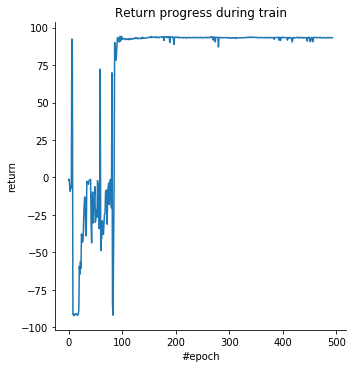

In [109]:
ax = sns.relplot(x=range(data_return.shape[0]),y='return',kind='line',data=data_return)
ax.set(xlabel='#episode',ylabel='return',title="Return progress during trainning")

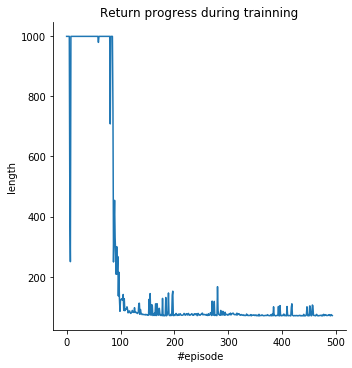

In [117]:
ax4 = sns.relplot(x=range(data_return.shape[0]),y='eplength',kind='line',data=data_return)
ax4.set(xlabel='#episode',ylabel='length',title="Return progress during trainning")

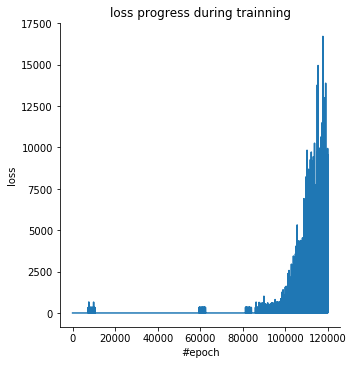

In [115]:
ax2 = sns.relplot(x=range(data_loss.shape[0]),y='critic',kind='line',data=data_loss)
ax2.set(xlabel='#epoch',ylabel='loss',title="loss progress during trainning")

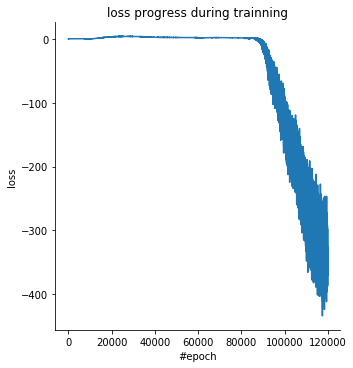

In [116]:
ax3 = sns.relplot(x=range(data_loss.shape[0]),y='actor',kind='line',data=data_loss)
ax3.set(xlabel='#epoch',ylabel='loss',title="loss progress during trainning")

In [1]:
import gym
import sys,os
sys.path.append(os.pardir)
from ddpg.class_NN import *
from copy import deepcopy
env = gym.make('MountainCarContinuous-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/donghyun/anaconda2/envs/gym_torch/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
num_test = 100
ac = torch.load('ddpg.pth')
ac.eval()

AC_Agent(
  (actor): Actor(
    (policy_mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Tanh()
    )
  )
  (critic): Critic(
    (Q_mlp): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [3]:
ac.critic

Critic(
  (Q_mlp): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Identity()
  )
)

In [4]:
gauss_noise = 0.1
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]
def get_action(o, noise_scale):
    o = torch.from_numpy(o)
    a = ac.act(o)
    a = a.to("cpu").numpy()
    noise = np.random.randn(act_dim).astype(np.float32)
    a += noise_scale * noise
    return np.clip(a, -act_limit, act_limit)


In [ ]:
ep_len_history = []
ep_return_history = []
gamma = 0.99
num_test = 100
for i in range(num_test):
    d = False
    o = env.reset()
    ep_len = 0
    ep_return = 0
    while not d:
        a = get_action(o, 0)
        o_, r, d, _ = env.step(a)
        env.render()
        o = o_
        ep_len+=1
        ep_return += gamma*r
    ep_len_history.append(ep_len)
    ep_return_history.append(ep_return_history)
        

# Test Agent

In [1]:
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def mlp(layer_sizes,act,out_act=nn.Identity):
    layers=[]
    for i in range(len(layer_sizes)-1):
        ac = act if i<len(layer_sizes)-2 else out_act
        layers += [nn.Linear(layer_sizes[i], layer_sizes[i+1]),ac()]
    return nn.Sequential(*layers)

In [3]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, args):
        super().__init__()
        self.pi_size = [state_size] + args.hidden_sizes + [action_size] 
        self.pi_mlp = mlp(self.pi_size, nn.ReLU)
    def forward(self, x):
        return self.pi_mlp(x)

In [4]:
import easydict
args = easydict.EasyDict({"env_name" : "Pendulum-v0",
                          'load_model':None,
                          "save_path" : "./gdrive/My Drive/Colab Notebooks/save_model/",
                          "render":False,
                          'gamma':0.99,
                          "hidden_sizes":(128,128),
                          "batch_size":128,
                          "actor_lr":1e-4,
                          "critic_lr":1e-3,
                          "theta":0.15,
                          'mu':0.0,
                          'sigma':0.3,
                          'tau':0.001,
                          'gradient_clip_actor':0.5,
                          'gradient_clip_critic':1.0,
                          'max_iter_num':1000,
                          'log_interval':10,
                          'goal_score':-350,
                          'logdir': "./gdrive/My Drive/Colab Notebooks/logs/",
                          'test_iter':1000,
                          'model':"model.pth.tar",
                          }) 

In [5]:
class OUNoise:
    def __init__(self, action_size, theta, mu, sigma):
        self.action_size = action_size
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.X = np.zeros(self.action_size) 

    def sample(self):
        dx = self.theta * (self.mu - self.X) + self.sigma * np.random.randn(len(self.X))
        self.X = self.X + dx
        
        return self.X

def get_action(policy, ou_noise, env):
    policy = policy.cpu()
    action = policy.detach().numpy() +ou_noise.sample() #0.01*np.random.randn(policy.shape[0])
    action = np.clip(action, env.action_space.low, env.action_space.high)
    return action

In [ ]:
import gym
import gym.wrappers as wrappers

env_to_wrap = gym.make(args.env_name)
env = wrappers.Monitor(env_to_wrap, '../ddpg/wrapper',force=True)
env.seed(500)
torch.manual_seed(500)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

actor = Actor(state_size,action_size,args)


tr_model_path = 'final_model.pth.tar'
tr_model = torch.load(tr_model_path)
actor.load_state_dict(tr_model)

ou_noise = OUNoise(action_size, 0, 0, 0)
steps = 0

for episode in range(args.test_iter):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1,state_size])

    while not done:
        env.render()
        steps +=1
        policy = actor(torch.Tensor(state)).to(device)
        action = get_action(policy, ou_noise, env)
                    
        next_state, reward, done, _ = env.step(action)
        
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        score += reward
    if episode % args.log_interval == 0:
        print('{} episode | score: {:.2f}'.format(episode, score[0]))
env.close()
env_to_wrap.close()

/home/donghyun/anaconda2/envs/gym_torch/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 episode | score: -134.89
10 episode | score: -136.27
